# **Milestone 2, Phase 2**

`Julio Muhammad Rizki, FTDS Batch 003-HCK`

# Introduction

Dataset yang akan digunakan pada Notebook ini berasal dari Eurosat Dataset yang berbentuk gambar. Setiap gambar berukuran 64x64 pixel berdasarkan sample yang diambil dari jarak 10m. Gambar-gambar tersebut diambil dari Satellite Sentinel-2.

Gambar sudah dipisahkan berdasarkan kelasnya kedalam masing-masing folder. Kelas-kelas tersebut adalah :
- AnnualCrop
- Forest
- HerbaceousVegatation
- Highway
- Industrial
- Pasture
- PermanentCrop
- Residential
- River
- SeaLake

link dataset : https://www.kaggle.com/datasets/apollo2506/eurosat-dataset

link deployment : https://huggingface.co/spaces/juliomrizki/Satellite-Image-Predict

# Library Import

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

# Data Loading

Pertama-tama akan ditentukan random seed untuk memudahkan pengerjaan apabila notebook/kernel perlu dilakukan restart atau "run all".

In [2]:
tf.random.set_seed(14)

Kemudian dilakukan definisi Batch Size, Image Size, dan Channels

In [3]:
BATCH_SIZE = 32
IMG_SIZE = 64
CHANNELS = 3

Dilakukan Data Loading dari Folder yang sudah tersimpan.

In [46]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Hacktiv8\Milestone\p2---ftds-003-hck--m2-juliomrizki\EuroSAT",
    label_mode = 'categorical',
    color_mode= 'rgb',
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE   
)

Found 27000 files belonging to 10 classes.


Total data adalah 27 ribu file yang terbagi kedalam 10 kelas.

# Exploratory Data Analysis

Berikut adalah nama-nama kelas dari data tersebut.

In [5]:
class_names = data.class_names
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

Berikut adalah contoh-contoh dari gambar berdasarkan kelas-kelasnya.

(32, 64, 64, 3)


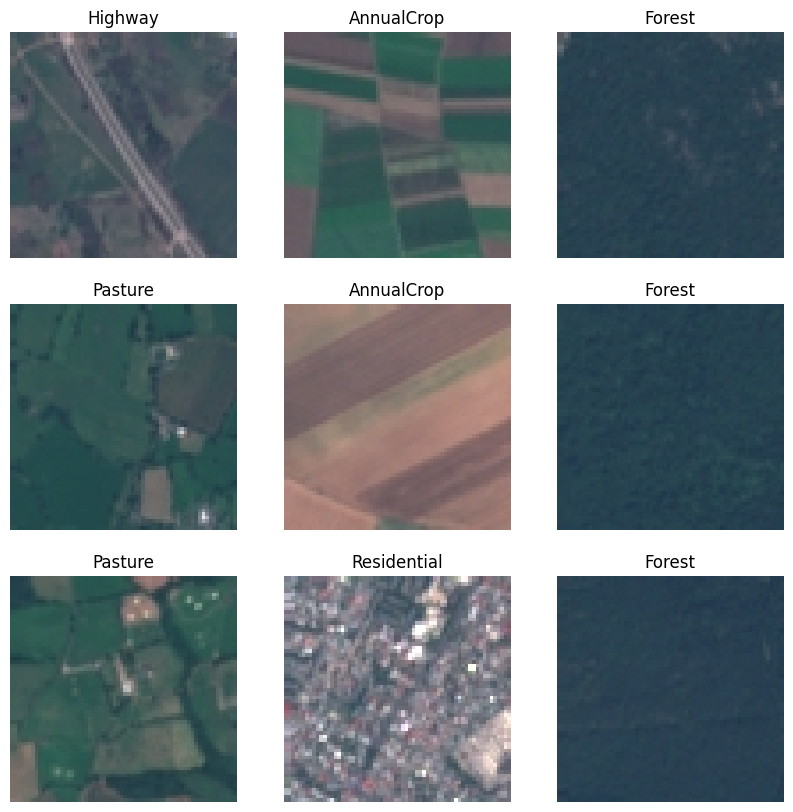

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in data.take(1):
    print(image_batch.shape)
    for i in range(0,9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

Dari data yang ada, akan dibagi kedalam data test, data train, dan data val untuk memudahkan pelatihan dan pengetesan terhadap model.

In [47]:
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
    
train_data = data.take(train_size)    
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size).skip(val_size)

In [8]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32, 10)


Data-data tersebut sudah dibagi kedalam batch berukuran 32. Berikut adalah jumlah batch pada setiap split data.

In [9]:
print('Jumlah batch dalam Train Data :', len(train_data))
print('Jumlah batch dalam Validation Data :', len(val_data))
print('Jumlah batch dalam Test Data :', len(test_data))

Jumlah batch dalam Train Data : 590
Jumlah batch dalam Validation Data : 168
Jumlah batch dalam Test Data : 86


Data-data tersebut kemudian dilakukan prefetch untuk meningkatkan efisiensi mesin dalam melakukan deep-learning.

In [48]:
data_train = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
data_val = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
data_test = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Preprocessing

Selanjutnya, gambar-gambar pada data akan dilakukan resize dan rescale. Pada case ini tidak dilakukan augmentasi karena augmentasi pada data ini (gambar-gambar dari satelite) tidak memberikan penambahan pada akurasi ataupun mengurasi jumlah loss yang signifikan. 

Augmentasi data disini hanya meningkatkan waktu training pada model tanpa memberikan pengaruh yang cukup berarti (beberapa kali dilakukan percobaan saat tuning, justru data yang di augmentasi skornya lebih rendah).

In [49]:
def resize_and_rescale(image):
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = tf.divide(image, 255.)
  return image

data_train = data_train.map(lambda x, y: (resize_and_rescale(x), y))
data_val = data_val.map(lambda x, y: (resize_and_rescale(x), y))
data_test = data_test.map(lambda x, y: (resize_and_rescale(x), y))

# Model Definition

Berikutnya, dibuatkan model CNN dengan metode Sequential hanya dengan beberapa parameter baseline.

In [12]:
input_shape = (IMG_SIZE, IMG_SIZE, CHANNELS)
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(2, 2)) 
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

Berikut adalah ringkasan dari parameter model baseline yang dipakai.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

# Model Training

Model kemudian dilakukan training pada percobaan 100 epoch.

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
history = model.fit(data_train, batch_size = BATCH_SIZE, epochs=100, validation_data = data_val, verbose = 1)

Epoch 1/100
590/590 [==============================] - 83s 44ms/step - loss: 1.4762 - accuracy: 0.4173 - val_loss: 1.3415 - val_accuracy: 0.4747
Epoch 2/100
590/590 [==============================] - 6s 10ms/step - loss: 0.9860 - accuracy: 0.6354 - val_loss: 0.8706 - val_accuracy: 0.6682
Epoch 3/100
590/590 [==============================] - 6s 10ms/step - loss: 0.7803 - accuracy: 0.7168 - val_loss: 0.7496 - val_accuracy: 0.7370
Epoch 4/100
590/590 [==============================] - 6s 10ms/step - loss: 0.6736 - accuracy: 0.7561 - val_loss: 0.6171 - val_accuracy: 0.7786
Epoch 5/100
590/590 [==============================] - 6s 10ms/step - loss: 0.6139 - accuracy: 0.7788 - val_loss: 0.6342 - val_accuracy: 0.7768
Epoch 6/100
590/590 [==============================] - 6s 11ms/step - loss: 0.5693 - accuracy: 0.7933 - val_loss: 0.5665 - val_accuracy: 0.8049
Epoch 7/100
590/590 [==============================] - 6s 11ms/step - loss: 0.5267 - accuracy: 0.8115 - val_loss: 0.5571 - val_accuracy

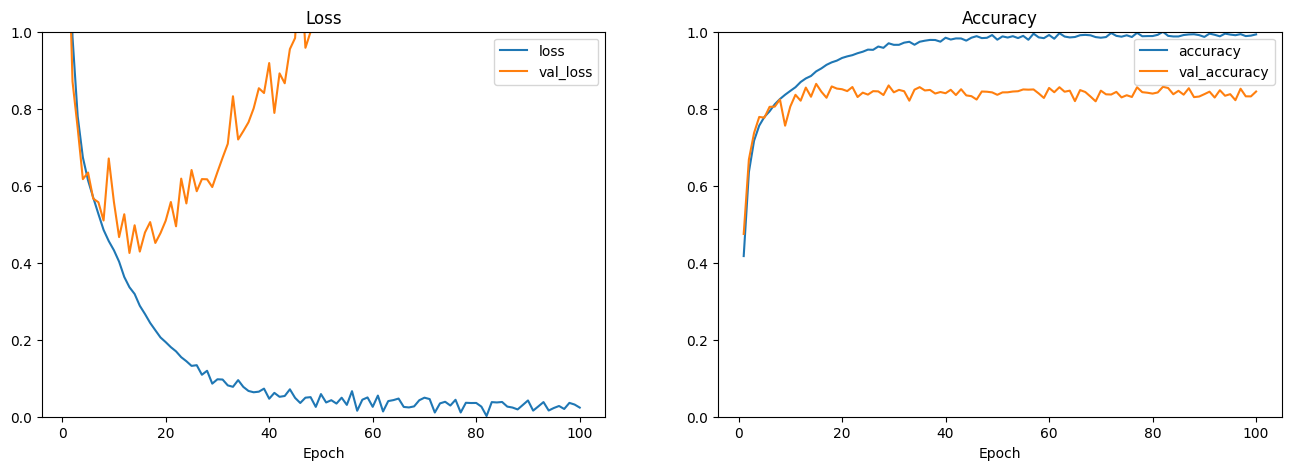

In [34]:
epoch=100

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(0.0,1.0)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0.0,1.0)

plt.show()

Berdasarkan hasil visualisasi, dapat dilihat bahwa pada nilai akurasi, model mengalami overfit yang cukup besar. Dan pada tingkat loss, ditemukan loss yang cukup tinggi dan terus bertambah pada setiap epochnya pada validasi. Hal ini dapat dianggap karena terjadinya model overfitting. 

Berikutnya akan dilakukan beberapa tuning pada model untuk memberikan hasil yang diharapkan lebih baik dari model baseline.

In [18]:
input_shape = (IMG_SIZE, IMG_SIZE, CHANNELS)
model_tuned = tf.keras.models.Sequential()

model_tuned.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding = 'same',input_shape=input_shape, kernel_initializer="he_normal"))
model_tuned.add(tf.keras.layers.MaxPooling2D(2, 2))
model_tuned.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding = 'same', kernel_initializer="he_normal")) 
model_tuned.add(tf.keras.layers.MaxPooling2D(2, 2)) 
model_tuned.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding = 'same', kernel_initializer="he_normal")) 
model_tuned.add(tf.keras.layers.MaxPooling2D(2, 2))
model_tuned.add(tf.keras.layers.GlobalAveragePooling2D())
model_tuned.add(tf.keras.layers.Dropout(0.5))
model_tuned.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal"))
model_tuned.add(tf.keras.layers.Dense(10, activation='softmax'))

Berikut adalah ringkasan dari parameter model tuning.

In [19]:
model_tuned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 128)       

In [20]:
model_tuned.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_tuned = model_tuned.fit(data_train, batch_size = BATCH_SIZE, epochs=50, validation_data = data_val, verbose = 1)

Epoch 1/50
590/590 [==============================] - 8s 12ms/step - loss: 1.4939 - accuracy: 0.4350 - val_loss: 1.0400 - val_accuracy: 0.6025
Epoch 2/50
590/590 [==============================] - 7s 12ms/step - loss: 1.0151 - accuracy: 0.6314 - val_loss: 0.8420 - val_accuracy: 0.6875
Epoch 3/50
590/590 [==============================] - 7s 12ms/step - loss: 0.8048 - accuracy: 0.7106 - val_loss: 0.7007 - val_accuracy: 0.7381
Epoch 4/50
590/590 [==============================] - 7s 12ms/step - loss: 0.7150 - accuracy: 0.7408 - val_loss: 0.5859 - val_accuracy: 0.7948
Epoch 5/50
590/590 [==============================] - 7s 13ms/step - loss: 0.6575 - accuracy: 0.7642 - val_loss: 0.5563 - val_accuracy: 0.7976
Epoch 6/50
590/590 [==============================] - 7s 12ms/step - loss: 0.6112 - accuracy: 0.7826 - val_loss: 0.5313 - val_accuracy: 0.8078
Epoch 7/50
590/590 [==============================] - 7s 11ms/step - loss: 0.5851 - accuracy: 0.7891 - val_loss: 0.5274 - val_accuracy: 0.8103

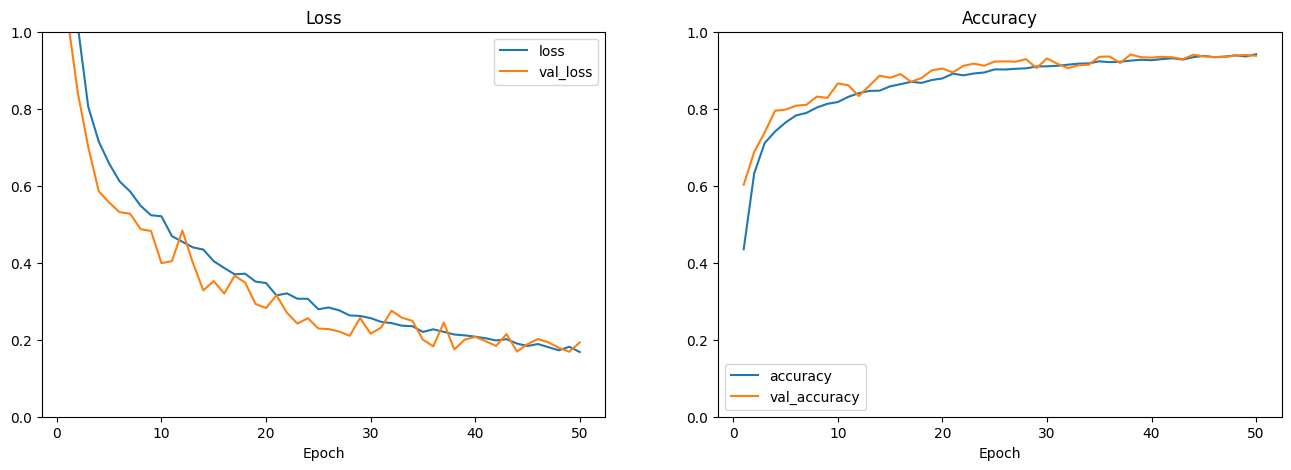

In [21]:
epoch=50

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history_tuned.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history_tuned.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(0.0,1.0)

ax[1].plot(range(1,epoch+1),history_tuned.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history_tuned.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0.0,1.0)

plt.show()

Setelah dilakukan berulang kali percobaan pada penggantian jumlah hidden layer berbeda, model yang berbeda, activation, pooling, jumlah epoch, penggantian globalavgpooling dan flatten, jumlah dropout, batchnormalization, penggunaan model pre-trained, dan kernel initializer. Ditemukan bahwa parameter yang digunakan diatas menghasilkan model yang paling cukup stabil.

# Model Evaluation

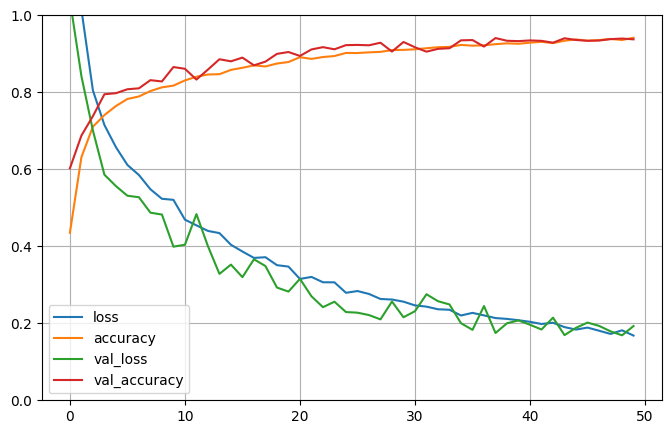

In [22]:
pd.DataFrame(history_tuned.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.0, 1.0)
plt.show()

Hasil dari model yang dituning dapat disimpulkan sebagai berikut :

- Akurasi pada model cukup baik, pada 94% dengan hanya sedikit gradient problem
- Loss pada train disini sebetulnya lebih besar jika dibandingkan dengan baseline model, namun loss pada validation dapat dikatakan jauh lebih baik. 
- Di beberapa case pada bercobaan, ditemukan banyak sekali percobaan dengan tingkat akurasi yang tidak jauh berbeda, namun kebanyakan percobaan-percobaan tersebut memiliki tingkat loss yang cukup tinggi. Khususnya pada hidden layer yang terlalu banyak, tidak menggunakan padding, dan percobaan pada beberapa model berbeda.
- Walaupun model belum menemukan titik convergen yang cukup baik, dapat dikatakan model cukup layak digunakan untuk memprediksi gambar satelite.

In [51]:
train_eval = model_tuned.evaluate(data_train, verbose=1)
val_eval = model_tuned.evaluate(data_val, verbose=1)
test_eval = model_tuned.evaluate(data_test, verbose=1)

86/86 [==============================] - 11s 5ms/step - loss: 0.1545 - accuracy: 0.9497


Pada hasil evaluate juga dapat dilihat bahwa pada data train, val, dan test semuanya memiliki akurasi dan loss yang serupa. Sehingga dapat dikatakan model memiliki best fit.

# Model Inference

Model inference akan dilakukan pada notebook alternatif.

## Model Saving

In [67]:
model_tuned.save('model_tuned.h5')

# Overall Analysis

Pada Notebook ini dilakukan pemodelan CNN Classification untuk mengklasifikasi 10 kelas berdasarkan jenis lokasi berdasarkan gambar satelite.

Pada gambar, hanya diberlakukan resize dan rescale. Hal ini dikarenakan percobaan menggunakan augmentasi data justru menghambat/mengurangi performa dari kemampuan model belajar.

Proses pembuatan model dilakukan dengan Optimizer Adam dan setelah dilakukan Fine Tuning dengan melatih semua layer yang telah didefinisikan didalam model tersebut. Total parameter yang dilatih sebanyak 102,154 parameter. Jumlah parameter tergolong tidak tinggi dalam pelatihan model CNN karena menggunakan GlobalAveragePooling2d

Hasil dari evaluasi menunjukkan model memiliki akurasi dengan tingkat 94%

Kekurangan dari model ini mungkin dapat terlihat pada tingkat loss yang masih dapat dikurangi lagi dengan metode tuning lainnya. 

Peneliti menggunakan beberapa percobaan pada base model dan sebuah percobaan dengan pre-trained model VGG16. Namun memutuskan hasil tuning yang lebih baik pada penggunaan model yang dituning manual sebagaimana diatas. Diperkirakan masih ada berbagai macam pre-trained model yang lebih cocok digunakan dalam Notebook ini dengan tingkat performa yang lebih baik lagi.